In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

main_directory = r'C:\Users\ASUS\Desktop\ML-data science\DataIncubator\yelp-cleaners' + '\\'
processed_data_directory = main_directory + r'data\processed data' + '\\'

In [2]:
# business_df_latest = pd.read_csv(processed_data_directory + 'business_df_latest_inspection.csv')
# business_df = pd.read_csv(processed_data_directory + 'business_df.csv')
# review_df = pd.read_csv(processed_data_directory + 'review_df.csv')

In [110]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, LogisticRegression
from sklearn import datasets, tree, utils
from sklearn import model_selection, ensemble
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from collections import Counter
import re

In [4]:
import spacy
# nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
STOP_WORDS = STOP_WORDS.union({'ll', 've'})
from sklearn.naive_bayes import MultinomialNB, GaussianNB

# Topic modeling

In [268]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser','ner','textcat'])

In [269]:
def my_lemmatizer(doc):
    doc_cleaned = ' '.join(re.findall(r'\b\w[\w\']+\b', doc))
    return [ w.lemma_.lower() for w in nlp(doc_cleaned) 
                      if w.lemma_ not in ['_', '.', '-PRON-'] ]

stopwords = spacy.lang.en.stop_words.STOP_WORDS
# Removing a few words that don't lemmatize well
stopwords = stopwords.difference({'he','his','her','hers'})

stopwords = set(my_lemmatizer(' '.join(sorted(stopwords))))
# add some annoying ones that get through lemmatizer
stopwords = stopwords.union({'\'s', '\'ll', '\'ve'})

In [270]:
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

In [271]:
# let's just look at businesses with >100 reviews
num_reviews = df.business_id.value_counts()
valid_businesses = num_reviews[num_reviews >= 100].index
df = df[df['business_id'].isin(valid_businesses)].reset_index(drop=True)

In [272]:
# only look at outraged customers
df = df[df.review_stars <= 2]

In [273]:
reviews = df['text']
scores = df['Score']
X, y = shuffle(reviews, scores, random_state=42)
cutoff = -1
X, y = X[:cutoff], y[:cutoff]
# round
roundby = 5
y = y.apply(lambda x: math.ceil(x / roundby) * roundby)

In [274]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [275]:
%%time
max_features = 1000
cv = CountVectorizer(tokenizer=my_lemmatizer, stop_words=stopwords, 
                     min_df=2, max_df=0.95, max_features=max_features)
counts = cv.fit_transform(X)

Wall time: 7min 24s


In [216]:
%%time
tf = TfidfTransformer()
matrix = tf.fit_transform(counts)

Wall time: 6 ms


## K-means clustering

In [223]:
number_of_clusters = 50

kmc_5 = KMeans(n_clusters=number_of_clusters, n_init=3, random_state=117)  # random_state for consistency
kmc_5.fit(matrix)

KMeans(n_clusters=50, n_init=3, random_state=117)

In [252]:
top_words_df = {'top_words':[[terms[k] for k in cluster_words[i][-number_of_top_words:]] for i in range(50)]}
top_words_df = pd.DataFrame(top_words_df)

In [262]:
top_words_df.top_words[top_words_df.top_words.apply(lambda x: 'dirty' in x)].values

array([list(['fact', 'fun', 'cashier', 'incredibly', 'bag', 'type', 'street', 'concern', 'poorly', 'pre', 'complaint', 'come', 'employee', 'spread', 'work', 'box', 'fan', 'texas', 'old', 'know', 'process', 'awful', 'location', 'fine', 'people', 'place', 'fill', 'complimentary', 'heat', 'line', 'poor', 'pretty', 'good', 'dirty', 'cash', 'want', 'water', 'happen', 'attitude', 'long', 'experience', 'matter', 'write', 'uncomfortable', 'air', 'stand', 'thing', 'suck', 'stale', 'donut']),
       list(['expensive', 'hope', 'care', 'expect', 'tasty', 'smell', 'music', 'slow', 'treat', 'unfortunately', 'disgusting', 'forget', 'attitude', 'booth', 'nice', 'vomit', 'table', 'stuff', 'base', 'buffet', 'garbage', 'friendly', 'work', 'disappointing', 'maybe', 'order', 'walk', 'child', 'bad', 'olive', 'hand', 'management', 'come', 'area', 'waitress', 'opening', 'floor', 'problem', 'review', 'trash', 'service', 'people', 'like', 'know', 'restroom', 'nasty', 'place', 'good', 'food', 'dirty'])],
      d

In [237]:
'dirty' in top_words

True

In [230]:
number_of_top_words = 50
cluster_words = np.argsort(kmc_5.cluster_centers_, axis=1)
terms = cv.get_feature_names_out()

top_words = set()

for i in range(number_of_clusters):
#     print(f'Cluster {i}: ')
    print(' '.join([terms[k] for k in cluster_words[i][-number_of_top_words:]]),'\n')
    top_words = top_words.union([terms[k] for k in cluster_words[i][-number_of_top_words:]])
    
top_words = sorted(list(top_words))

cook bother stand bottle manager yell avocado mess plan attention basically 00 slow drop 30 restaurant 20 receive waitress mouth friend miss finally run water people pm zero pay great start hand mention bagel anytime wash bad tell eye order service meet time way place hold roll ask food his 

seriously evening old actually friendly biscuit meal poke worker party boyfriend okay expectation way bread restroom avoid busy totally order meh eat 40 menu bit awesome world minute pad breakfast atmosphere wait time good brunch look set place sad cupcake server love like service weekend vibe little great food bad 

available portion receive deserve annoying completely think little fire avocado pickup waiter bag dinner seat read pick despite way fine definitely probably multiple people small yelp come hard service force leave day glove long bad work restaurant good bar food star item pretty place understand experience time order review owner 

check wing refill spinach additional week group 50 gr

In [225]:
'dirty' in top_words

True

In [227]:
word_df = pd.DataFrame(counts.toarray(), columns=terms)[top_words]
word_df['Cluster'] = kmc_5.labels_.tolist()

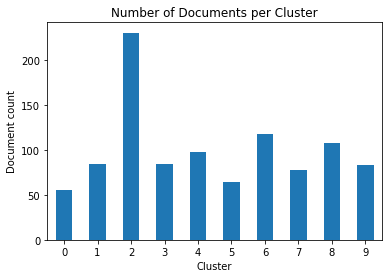

In [167]:
word_df.groupby('Cluster').count()[top_words[0]].\
    plot.bar(rot=0).\
    set(ylabel='Document count',
    title='Number of Documents per Cluster');

(array([35.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
         4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.  ,  0.22,  0.44,  0.66,  0.88,  1.1 ,  1.32,  1.54,  1.76,
         1.98,  2.2 ,  2.42,  2.64,  2.86,  3.08,  3.3 ,  3.52,  3.74,
         3.96,  4.18,  4.4 ,  4.62,  4.84,  5.06,  5.28,  5.5 ,  5.72,
         5.94,  6.16,  6.38,  6.6 ,  6.82,  7.04,  7.26,  7.48,  7.7 ,
         7.92,  8.14,  8.36,  8.58,  8.8 ,  9.02,  9.24,  9.46,  9.68,
         9.9 , 10.12, 10.34, 10.56, 10.78, 11.  ]),
 <BarContainer object of 50 artists>)

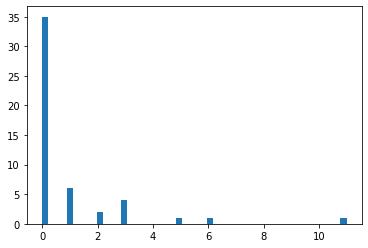

In [229]:
plt.hist(word_df.groupby('Cluster').agg({'dirty':'sum'}),bins = 50)

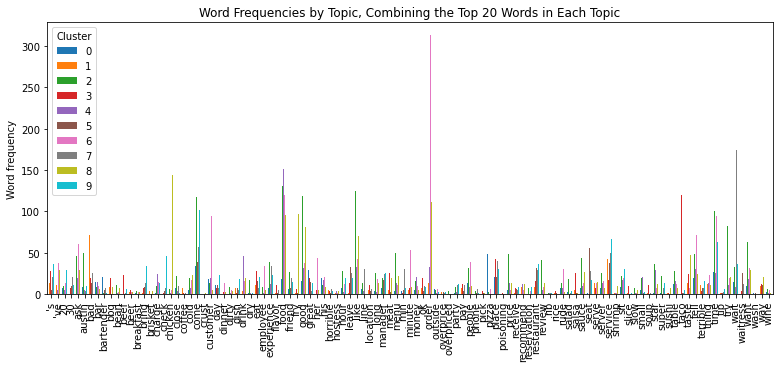

In [169]:
word_df.groupby('Cluster').sum().transpose().\
    plot.bar(figsize=(13,5), width=0.7).\
    set(ylabel='Word frequency', 
    title=f'Word Frequencies by Topic, Combining the Top {number_of_top_words} Words in Each Topic');

In [170]:
word_totals = { i: word_df.groupby('Cluster').sum().loc[i].to_dict() for i in range(number_of_clusters) }

In [264]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from wordcloud import WordCloud

def show_wordcloud(topic=0):
    cloud = WordCloud(background_color='white', colormap='viridis')
    cloud.generate_from_frequencies(word_totals[topic])
    plt.gca().imshow(cloud)
    plt.axis('off')
    plt.tight_layout()
    
slider = IntSlider(min=0, max=number_of_clusters-1, step=1, value=0, description='Topic')
interact(show_wordcloud, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=49), Output()), _dom_classes=('widget-intera…